# Kappa Model in Omega

In [1]:
## Load Packages
using Omega
using StatsBase
using Random
using Plots
using Distributions
using PyCall
using DataStructures

┌ Info: Recompiling stale cache file C:\Users\Devon Kohler\.julia\compiled\v1.0\PyCall\GkzkC.ji for PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1190
rec_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\stackwalk.c:94
record_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:246
jl_throw at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:577
jl_bounds_error_ints at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\rtutils.c:187
getindex at .\array.jl:731
jfptr_getindex_2272.clone_1 at C:\Users\Devon Kohler\AppData\Local\Julia-1.0.5\lib\julia\sys.dll (unknown line)
jl_apply_generic at /home/Administrator/buildbot/worker/package_win64/build/src/home/Admin

## Load SBML

In [3]:
te = pyimport("tellurium")
sbml = te.loadSBMLModel("kappa_resimulation_figure2.sbml")
ant = te.sbmlToAntimony("kappa_resimulation_figure2.sbml")
print(ant)

// Created by libAntimony v2.12.0.3
model *kappa_resimulation_figure2()

  // Compartments and Species:
  compartment default;
  substanceOnly species __s0 in default, __s1 in default, __s2 in default;
  substanceOnly species __s3 in default, __s4 in default, __s5 in default;
  substanceOnly species __s6 in default, __s7 in default;

  // Assignment Rules:
  __obs0 := __s0 + __s3 + __s5;
  __obs1 := __s1 + __s3 + __s4;

  // Reactions:
  r0: __s0 => __s2; __s0*mod_rate_slow;
  r1: __s0 + __s1 -> __s3; __s0*__s1*on_rate - __s3*off_rate_fast;
  r2: __s3 => __s4; __s3*mod_rate_slow;
  r3: __s1 + __s2 -> __s4; __s1*__s2*on_rate - __s4*off_rate_slow;
  r4: __s3 => __s5; __s3*mod_rate;
  r5: __s5 => __s6; __s5*mod_rate_slow;
  r6: __s5 -> __s0 + __s7; -(__s0*__s7*on_rate) + __s5*off_rate_fast;
  r7: __s4 => __s6; __s4*mod_rate;
  r8: __s2 + __s7 -> __s6; __s2*__s7*on_rate - __s6*off_rate_slow;

  // Species initializations:
  __s0 = K_0;
  __s1 = S_0;
  __s2 = 0;
  __s3 = 0;
  __s4 = 0;
  __

## Build Model

In [7]:
function get_parameters(sbml_file_path)
        
    """
    Function to extract model parameters from sbml. Returns dictionary with 
    a transition matrix, species list, and rates list.
    """
    ## Load SBML
    sbml = te.loadSBMLModel("kappa_resimulation_figure2.sbml")

    ## Transition Matrix
    transition = sbml.getFullStoichiometryMatrix()
    transition = [transition[i, :] for i in 1:size(transition, 1)]
    
    ## Extract Species
    species_ids = sbml.getFloatingSpeciesIds()
    species_starting_vals = sbml.getFloatingSpeciesAmounts()
    species = Dict(species_ids .=> species_starting_vals)
    
    ## Extract Rates
    rates = Dict(sbml.getGlobalParameterIds() .=> sbml.getGlobalParameterValues())
    
    return Dict("transition" => transition, "species" => species, "rates" => rates)
    
end

get_parameters (generic function with 1 method)

In [9]:
model_params = get_parameters("kappa_resimulation_figure2.sbml")
t = transpose(model_params["transition"])
species = model_params["species"]
rates = model_params["rates"]
print()

In [77]:
function full_sim(rng, n, theta)
    
    """
    Function to sample from given hazard values. Takes previous species values and outputs the se3ected hazard and if that hazard was negative.
    """
    
    ecology = OrderedDict("__s0" => S0_list[n](rng), "__s1" => S1_list[n](rng), "__s2" => S2_list[n](rng), 
        "__s3" => S3_list[n](rng), "__s4" => S4_list[n](rng),"__s5" => S5_list[n](rng), "__s6" => S6_list[n](rng), 
        "__s7" => S7_list[n](rng), "time" => time_list[n](rng))
    
    haz = OrderedDict(sbml.getReactionIds() .=> [
        ecology["__s0"]*theta["mod_rate_slow"],
        ecology["__s0"]*ecology["__s1"]*theta["on_rate"] - ecology["__s3"]*theta["off_rate_fast"],
        ecology["__s3"]*theta["mod_rate_slow"],
        ecology["__s1"]*ecology["__s2"]*theta["on_rate"] - ecology["__s4"]*theta["off_rate_slow"],
        ecology["__s3"]*theta["mod_rate"],
        ecology["__s5"]*theta["mod_rate_slow"],
        -(ecology["__s0"]*ecology["__s7"]*theta["on_rate"]) + ecology["__s5"]*theta["off_rate_fast"],
        ecology["__s4"]*theta["mod_rate"],
        ecology["__s2"]*ecology["__s7"]*theta["on_rate"] - ecology["__s6"]*theta["off_rate_slow"]]
        )
    
    t = Any[]
    for (key, value) in haz
        if value < 0
            haz[key] = 0 - value
            push!(t, 1)
        else 
            push!(t, 0)
        end
    end
    
    ## Get values from hazard dictionary
    vals = collect(values(haz))
    sum_vals = sum(vals)
    ## Calculate probabilities
    prob_vals = vals/sum_vals
    ## Sample
    hazard_result = categorical(rng, prob_vals)
    
    ## Track species values
    push!(S0_vals, ecology["__s0"])
    push!(S1_vals, ecology["__s1"])
    push!(S2_vals, ecology["__s2"])
    push!(S3_vals, ecology["__s3"])
    push!(S4_vals, ecology["__s4"])
    push!(S5_vals, ecology["__s5"])
    push!(S6_vals, ecology["__s6"])
    push!(S7_vals, ecology["__s7"])
    push!(time_vals, ecology["time"])
    push!(reaction_samples, hazard_result)
    
    return hazard_result, t[hazard_result], sum_vals
    
end

function reaction_gen(rng, n)
    
    t_idx = ecology_list[n](rng)
    t = t_idx[1]
    return t
end

function S0_gen(rng, n, transition)
    
    """
    Individual function for each species. Need seperate random variables to apply interventions and conditionals.
    """
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S0_val = S0_vals[n] + update_val[1]
    S0_val = max(0, S0_val)
    return S0_val
end

function S1_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S1_val = S1_vals[n] + update_val[2]
    S1_val = max(0, S1_val)
    return S1_val
end
function S2_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S2_val = S2_vals[n] + update_val[3]
    S2_val = max(0, S2_val)
    return S2_val
end
function S3_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S3_val = S3_vals[n] + update_val[4]
    S3_val = max(0, S3_val)
    return S3_val
end
function S4_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S4_val = S4_vals[n] + update_val[5]
    S4_val = max(0, S4_val)
    return S4_val
end
function S5_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S5_val = S5_vals[n] + update_val[6]
    S5_val = max(0, S5_val)
    return S5_val
end
function S6_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S6_val = S6_vals[n] + update_val[7]
    S6_val = max(0, S6_val)
    return S6_val
end
function S7_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S7_val = S7_vals[n] + update_val[8]
    S7_val = max(0, S7_val)
    return S7_val
end
function time_gen(rng, n)
    t_idx = ecology_list[n](rng)
    haz_sum = t_idx[3]
    time_val = time_vals[n] + exponential(rng, haz_sum)
    return time_val
end

time_gen (generic function with 1 method)

In [85]:
function omega_simulation(theta, transition, starting_species, N_steps, seed, intervention = false)
    
    ## Initialize lists to hold random variables and species values
    global S0_list = Any[]; global S1_list = Any[]; global S2_list = Any[]
    global S3_list = Any[]; global S4_list = Any[]; global S5_list = Any[]
    global S6_list = Any[]; global S7_list = Any[]; global ecology_list = Any[]
    global time_list = Any[]; global reaction_list = Any[]
    
    global S0_vals = []; global S1_vals = []; global S2_vals = []
    global S3_vals = []; global S4_vals = []; global S5_vals = []
    global S6_vals = []; global S7_vals = []; global time_vals = []
    global reaction_samples = []
    
    ## Insert starting species values
    #insert!(S0_list, 1, normal(species["__s0"], .00001))
    insert!(S0_list, 1, uniform([starting_species["__s0"]]))
    insert!(S1_list, 1, uniform([starting_species["__s1"]]))
    insert!(S2_list, 1, uniform([starting_species["__s2"]]))
    insert!(S3_list, 1, uniform([starting_species["__s3"]]))
    insert!(S4_list, 1, uniform([starting_species["__s4"]]))
    insert!(S5_list, 1, uniform([starting_species["__s5"]]))
    insert!(S6_list, 1, uniform([starting_species["__s6"]]))
    insert!(S7_list, 1, uniform([starting_species["__s7"]]))
    insert!(time_list, 1, uniform([0]))
    
    ## Create random variables for each step
    for f in 2:N_steps
        last = f - 1
        push!(ecology_list, ciid(full_sim, last, theta))
        push!(reaction_list, ciid(reaction_gen, last))
        push!(S0_list, ciid(S0_gen, last, transition))
        push!(S1_list, ciid(S1_gen, last, transition))
        push!(S2_list, ciid(S2_gen, last, transition))
        push!(S3_list, ciid(S3_gen, last, transition))
        push!(S4_list, ciid(S4_gen, last, transition))
        push!(S5_list, ciid(S5_gen, last, transition))
        push!(S6_list, ciid(S6_gen, last, transition))
        push!(S7_list, ciid(S7_gen, last, transition))
        push!(time_list, ciid(time_gen, last))
    end
    
    ## Insert intervention if needed
    tracker = Dict("__s0" => S0_list, "__s1" => S1_list, "__s2" => S2_list, 
        "__s3" => S3_list, "__s4" => S4_list, "__s5" => S5_list, "__s6" => S6_list, 
        "__s7" => S7_list, "reaction" => reaction_list)
    
    if intervention != false
        intervene_list = tracker[intervention[1]]
        intervene_list[intervention[2]] = replace(intervene_list[intervention[2]], intervene_list[intervention[2]] => intervention[3])
    end

    ## Sample
    Random.seed!(seed)
    samples = rand(Tuple(ecology_list), 1, alg = RejectionSample)

    output = OrderedDict("S0" => S0_vals[1:N_steps-1], "S1" => S1_vals[1:N_steps-1], "S2" => S2_vals[1:N_steps-1], 
        "S3" => S3_vals[1:N_steps-1], "S4" => S4_vals[1:N_steps-1], "S5" => S5_vals[1:N_steps-1], "S6" => S6_vals[1:N_steps-1], 
        "S7" => S7_vals[1:N_steps-1], "time" => time_vals[1:N_steps-1], "reactions" => reaction_samples[1:N_steps-1])
    return output
    
end

omega_simulation (generic function with 2 methods)

## Run Simulation

In [107]:
simple_sim = omega_simulation(rates, t, species, 50000, 02)

OrderedDict{String,Array{Any,1}} with 10 entries:
  "S0"        => Any[1000.0, 999.0, 998.0, 997.0, 996.0, 995.0, 994.0, 993.0, 9…
  "S1"        => Any[100.0, 99.0, 98.0, 97.0, 96.0, 95.0, 94.0, 93.0, 92.0, 91.…
  "S2"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  901.0…
  "S3"        => Any[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  0.0, …
  "S4"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, …
  "S5"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, …
  "S6"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  99.0,…
  "S7"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, …
  "time"      => Any[0, 15537.1, 18232.1, 1.30283e5, 2.46793e5, 3.74559e5, 3.87…
  "reactions" => Any[2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  9, 9, 9, 9, 9, 9, 9, 9, 9…

In [108]:
plot(simple_sim["time"], hcat(simple_sim["S0"], simple_sim["S1"], simple_sim["S2"], simple_sim["S3"], simple_sim["S4"], simple_sim["S5"],
        simple_sim["S6"], simple_sim["S7"]),
        title = "Steady State Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S0/K" "S1/S" "S2" "S3" "S4" "S5" "S6" "S7"],
        lw = 1.25,
        legend = :outertopright)

In [113]:
t

9-element Array{Array{Float64,1},1}:
 [-1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
 [-1.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0] 
 [0.0, -1.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0, 0.0] 
 [0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0] 
 [1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0] 
 [0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0] 
 [0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0, -1.0]

Reaction #5 => "pk"

Reaction #2 => "b + u"

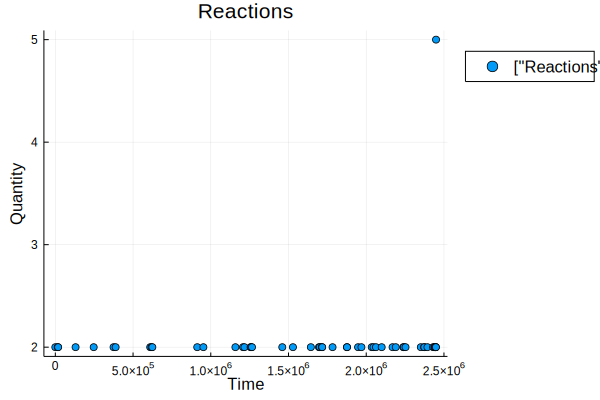

In [114]:
plot(simple_sim["time"][1:52], intervention_sim["reactions"][1:52],
        title = "Reactions",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Reactions"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

In [115]:
intervention_sim = omega_simulation(rates, t, species, 50000, 02, ("reaction", 20, 1))

OrderedDict{String,Array{Any,1}} with 10 entries:
  "S0"        => Any[1000.0, 999.0, 998.0, 997.0, 996.0, 995.0, 994.0, 993.0, 9…
  "S1"        => Any[100.0, 99.0, 98.0, 97.0, 96.0, 95.0, 94.0, 93.0, 92.0, 91.…
  "S2"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  901.0…
  "S3"        => Any[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  0.0, …
  "S4"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, …
  "S5"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, …
  "S6"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  99.0,…
  "S7"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, …
  "time"      => Any[0, 15537.1, 18232.1, 1.30283e5, 2.46793e5, 3.74559e5, 3.87…
  "reactions" => Any[2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  9, 9, 9, 9, 9, 9, 9, 9, 9…

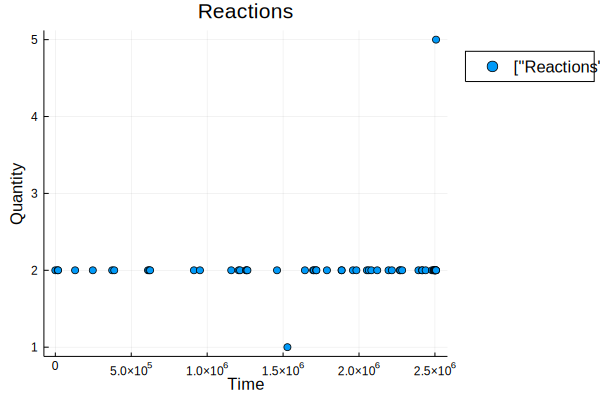

In [124]:
plot(intervention_sim["time"][1:55],vcat(intervention_sim["reactions"][1:19],[1],intervention_sim["reactions"][21:55]),
        title = "Reactions",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Reactions"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

In [123]:
findall(==(5), intervention_sim["reactions"][1:62])

1-element Array{Int64,1}:
 55

In [125]:
intervention_sim = omega_simulation(rates, t, species, 50000, 02, ("reaction", 51, 1))

OrderedDict{String,Array{Any,1}} with 10 entries:
  "S0"        => Any[1000.0, 999.0, 998.0, 997.0, 996.0, 995.0, 994.0, 993.0, 9…
  "S1"        => Any[100.0, 99.0, 98.0, 97.0, 96.0, 95.0, 94.0, 93.0, 92.0, 91.…
  "S2"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  901.0…
  "S3"        => Any[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  0.0, …
  "S4"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, …
  "S5"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, …
  "S6"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  99.0,…
  "S7"        => Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, …
  "time"      => Any[0, 15537.1, 18232.1, 1.30283e5, 2.46793e5, 3.74559e5, 3.87…
  "reactions" => Any[2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  9, 9, 9, 9, 9, 9, 9, 9, 9…

In [126]:
findall(==(5), intervention_sim["reactions"][1:62])

1-element Array{Int64,1}:
 55

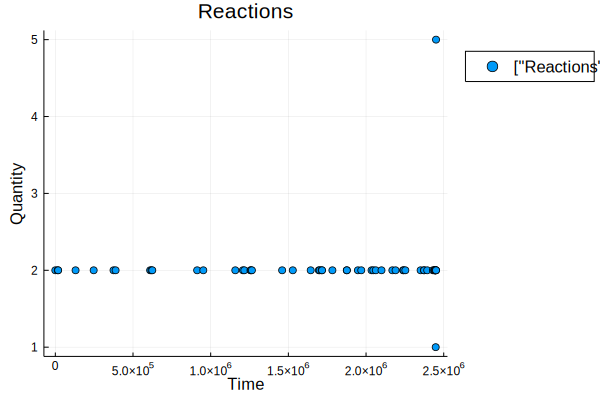

In [128]:
plot(intervention_sim["time"][1:55],vcat(intervention_sim["reactions"][1:50],[1],intervention_sim["reactions"][52:55]),
        title = "Reactions",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Reactions"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

## Dynamically create functions

In order to make this methodology applicable to any sbml, the model functions and code needs to be dynamically generated.

In [12]:
function full_sim(rng, n, theta, transition)
    
    """
    Function to sample from given hazard values. Takes previous species values and outputs the se3ected hazard and if that hazard was negative.
    """
    
    ecology = OrderedDict("__s0" => S0_list[n](rng), "__s1" => S1_list[n](rng), "__s2" => S2_list[n](rng), 
        "__s3" => S3_list[n](rng), "__s4" => S4_list[n](rng),"__s5" => S5_list[n](rng), "__s6" => S6_list[n](rng), 
        "__s7" => S7_list[n](rng), "time" => time_list[n](rng))
    
    haz = OrderedDict(sbml.getReactionIds() .=> [
        ecology["__s0"]*theta["mod_rate_slow"],
        ecology["__s0"]*ecology["__s1"]*theta["on_rate"] - ecology["__s3"]*theta["off_rate_fast"],
        ecology["__s3"]*theta["mod_rate_slow"],
        ecology["__s1"]*ecology["__s2"]*theta["on_rate"] - ecology["__s4"]*theta["off_rate_slow"],
        ecology["__s3"]*theta["mod_rate"],
        ecology["__s5"]*theta["mod_rate_slow"],
        -(ecology["__s0"]*ecology["__s7"]*theta["on_rate"]) + ecology["__s5"]*theta["off_rate_fast"],
        ecology["__s4"]*theta["mod_rate"],
        ecology["__s2"]*ecology["__s7"]*theta["on_rate"] - ecology["__s6"]*theta["off_rate_slow"]]
        )
    
    t = Any[]
    for (key, value) in haz
        if value < 0
            haz[key] = 0 - value
            push!(t, 1)
        else 
            push!(t, 0)
        end
    end
    
    ## Get values from hazard dictionary
    vals = collect(values(haz))
    sum_vals = sum(vals)
    ## Calculate probabilities
    prob_vals = vals/sum_vals
    ## Sample
    hazard_result = categorical(rng, prob_vals)
    
    t_selection = deepcopy(transition[hazard_result])
    if t[hazard_result] == 1
        for idx in 1:length(t_selection)
            t_selection[idx] = 0 - t_selection[idx]
        end
    end
    
    ## Track species values
    push!(__s0_vals, ecology["__s0"])
    push!(__s1_vals, ecology["__s1"])
    push!(__s2_vals, ecology["__s2"])
    push!(__s3_vals, ecology["__s3"])
    push!(__s4_vals, ecology["__s4"])
    push!(__s5_vals, ecology["__s5"])
    push!(__s6_vals, ecology["__s6"])
    push!(__s7_vals, ecology["__s7"])
    push!(time_vals, ecology["time"])
    push!(reaction_samples, hazard_result)
    
    return t_selection, sum_vals
    
end

function time_gen(rng, n)
    t_idx = ecology_list[n](rng)
    haz_sum = t_idx[2]
    time_val = time_vals[n] + exponential(rng, haz_sum)
    return time_val
end

## Dynamically generate species variables
for s in keys(species)
    @eval ($(Symbol("$(s)_gen"))) = (rng, n, idx) -> max(0, @eval Symbol("$(s)_vals")[n] + ecology_list[n](rng)[1][idx])
end

function omega_simulation(theta, transition, starting_species, N_steps, seed, intervention = false)
    
    ## Initialize lists to hold random variables and species values
    global S0_list = Any[]; global S1_list = Any[]; global S2_list = Any[]
    global S3_list = Any[]; global S4_list = Any[]; global S5_list = Any[]
    global S6_list = Any[]; global S7_list = Any[]; global ecology_list = Any[]
    global time_list = Any[]
    
    global __s0_vals = []; global __s1_vals = []; global __s2_vals = []
    global __s3_vals = []; global __s4_vals = []; global __s5_vals = []
    global __s6_vals = []; global __s7_vals = []; global time_vals = []
    global reaction_samples = []
    
    ## Insert starting species values
    #insert!(S0_list, 1, normal(species["__s0"], .00001))
    insert!(S0_list, 1, uniform([starting_species["__s0"]]))
    insert!(S1_list, 1, uniform([starting_species["__s1"]]))
    insert!(S2_list, 1, uniform([starting_species["__s2"]]))
    insert!(S3_list, 1, uniform([starting_species["__s3"]]))
    insert!(S4_list, 1, uniform([starting_species["__s4"]]))
    insert!(S5_list, 1, uniform([starting_species["__s5"]]))
    insert!(S6_list, 1, uniform([starting_species["__s6"]]))
    insert!(S7_list, 1, uniform([starting_species["__s7"]]))
    insert!(time_list, 1, uniform([0]))
    
    ## Create random variables for each step
    for f in 2:N_steps
        last = f - 1
        push!(ecology_list, ciid(full_sim, last, theta, t))
        push!(S0_list, ciid(__s0_gen, last, 1))
        push!(S1_list, ciid(__s1_gen, last, 2))
        push!(S2_list, ciid(__s2_gen, last, 3))
        push!(S3_list, ciid(__s3_gen, last, 4))
        push!(S4_list, ciid(__s4_gen, last, 5))
        push!(S5_list, ciid(__s5_gen, last, 6))
        push!(S6_list, ciid(__s6_gen, last, 7))
        push!(S7_list, ciid(__s7_gen, last, 8))
        push!(time_list, ciid(time_gen, last))
    end
    
    ## Insert intervention if needed
    tracker = Dict("__s0" => S0_list, "__s1" => S1_list, "__s2" => S2_list, 
        "__s3" => S3_list, "__s4" => S4_list, "__s5" => S5_list, "__s6" => S6_list, 
        "__s7" => S7_list)
    
    if intervention != false
        intervene_list = tracker[intervention[1]]
        intervene_list[intervention[2]] = replace(intervene_list[intervention[2]], intervene_list[intervention[2]] => intervention[3])
    end

    ## Sample
    Random.seed!(seed)
    samples = rand(Tuple(ecology_list), 1, alg = RejectionSample)
    print("ok")
    output = OrderedDict("S0" => __s0_vals[1:N_steps-1], "S1" => __s1_vals[1:N_steps-1], "S2" => __s2_vals[1:N_steps-1], 
        "S3" => __s3_vals[1:N_steps-1], "S4" => __s4_vals[1:N_steps-1], "S5" => __s5_vals[1:N_steps-1], "S6" => __s6_vals[1:N_steps-1], 
        "S7" => __s7_vals[1:N_steps-1], "time" => time_vals[1:N_steps-1], "reactions" => reaction_samples[1:N_steps-1])
    return output
    
end

omega_simulation (generic function with 2 methods)

In [23]:
for s in keys(species)
    @eval ($(Symbol("$(s)_gen"))) = (rng, n, idx) -> max(0, @eval Symbol("$(s)_vals")[n] + ecology_list[n](rng)[1][idx])
end


In [24]:
__s0_gen(1,2,3)

UndefVarError: UndefVarError: s not defined